<a href="https://www.kaggle.com/code/maulairfani/04-transfer-learning-in-tensorflow-part-1?scriptVersionId=117251490" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing and learned patterns for our own problems

In [1]:
# Are we using a GPU
!nvidia-smi

Wed Jan 25 05:54:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

## Download and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-01-25 05:54:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.210.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   133MB/s    in 1.2s    

2023-01-25 05:54:36 (133 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} image in '{dirpath}'")

There are 2 directories and 0 image in '10_food_classes_10_percent'
There are 10 directories and 0 image in '10_food_classes_10_percent/train'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/sushi'
There are

## Creating data loaders (preparing the data)

In [21]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


### Setting up callbacks (thing to run while our model trains)

some of the most popular:
1. Tracking experiment with the tensorboard callback
2. Model chckpoint with the ModelCheckpoint
3. Stopping a model from training (before it trains too long)

In [6]:
# Create TensorBoard callback
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to {log_dir}")
    return tensorboard_callback

## Creating models using TensorFlow Hub

In [7]:
# Let's compare the following two models
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [8]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential
    
    Args:
        model_url (str): A TensorFlow Hub feature extraction URL
        num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.
         
         
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons
    """
    # Download the pretrained model
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # (224, 224, 3)
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    
    return model

### Creating and testing ResNet TensorFlow Hub Feature extraction model

In [10]:
# Create resnet model
resnet_model = create_model(resnet_url)

2023-01-25 05:54:47.884878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 05:54:47.885822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 05:54:48.043719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 05:54:48.044586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 05:54:48.045362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [11]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

# Fit the data
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  callbacks=create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet50v2"))

2023-01-25 05:54:53.589014: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-25 05:54:53.589056: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-25 05:54:53.591301: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2023-01-25 05:54:54.023919: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-25 05:54:54.024114: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to tensorflow_hub/resnet50v2/20230125-055453


2023-01-25 05:54:54.398778: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-01-25 05:54:59.021105: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/24 [>.............................] - ETA: 4:37 - loss: 3.2661 - accuracy: 0.0938

2023-01-25 05:55:06.779319: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-25 05:55:06.779373: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/24 [=>............................] - ETA: 22s - loss: 3.1306 - accuracy: 0.1094 

2023-01-25 05:55:07.533024: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-25 05:55:07.533870: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-25 05:55:07.695221: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 336 callback api events and 333 activity events. 
2023-01-25 05:55:07.709075: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-25 05:55:07.731261: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/resnet50v2/20230125-055453/train/plugins/profile/2023_01_25_05_55_07



 3/24 [==>...........................] - ETA: 14s - loss: 3.0823 - accuracy: 0.1146

2023-01-25 05:55:07.740092: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tensorflow_hub/resnet50v2/20230125-055453/train/plugins/profile/2023_01_25_05_55_07/2205d9144e35.trace.json.gz
2023-01-25 05:55:07.780931: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/resnet50v2/20230125-055453/train/plugins/profile/2023_01_25_05_55_07

2023-01-25 05:55:07.788308: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tensorflow_hub/resnet50v2/20230125-055453/train/plugins/profile/2023_01_25_05_55_07/2205d9144e35.memory_profile.json.gz
2023-01-25 05:55:07.789472: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: tensorflow_hub/resnet50v2/20230125-055453/train/plugins/profile/2023_01_25_05_55_07
Dumped tool data for xplane.pb to tensorflow_hub/resnet50v2/20230125-055453/train/plugins/profile/2023_01_25

24/24 [==============================] - 32s 860ms/step - loss: 2.0494 - accuracy: 0.3227 - val_loss: 1.2699 - val_accuracy: 0.5904
Epoch 2/5
24/24 [==============================] - 17s 739ms/step - loss: 0.9156 - accuracy: 0.7253 - val_loss: 0.8632 - val_accuracy: 0.7328
Epoch 3/5
24/24 [==============================] - 18s 753ms/step - loss: 0.6131 - accuracy: 0.8333 - val_loss: 0.7502 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 18s 769ms/step - loss: 0.4714 - accuracy: 0.8707 - val_loss: 0.7154 - val_accuracy: 0.7672
Epoch 5/5
24/24 [==============================] - 19s 796ms/step - loss: 0.3776 - accuracy: 0.9147 - val_loss: 0.6796 - val_accuracy: 0.7816


In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
import matplotlib.pyplot as plt

# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separates loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.figure(figsize=(10,7))
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure(figsize=(10,7))
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

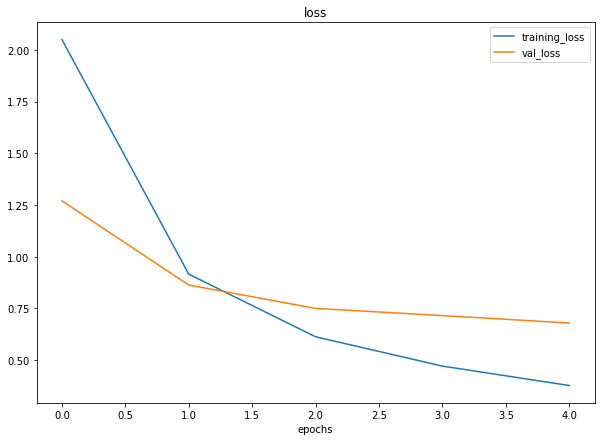

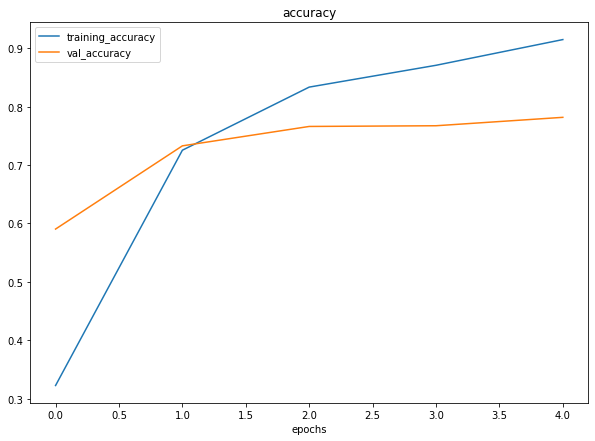

In [14]:
plot_loss_curves(history_resnet)

### Creating and testing EfficientNet TensorFlow Hub Feature extraction model

In [22]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                 num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

# Fit efficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                             epochs=5,
                                             steps_per_epoch=len(train_data_10_percent),
                                             validation_data=test_data,
                                             validation_steps=len(test_data),
                                             callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                   experiment_name="efficientnetb0")])

2023-01-25 06:01:49.406521: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-25 06:01:49.406582: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-25 06:01:50.156351: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-25 06:01:50.156564: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to tensorflow_hub/efficientnetb0/20230125-060149
Epoch 1/5
 1/24 [>.............................] - ETA: 3:24 - loss: 2.3277 - accuracy: 0.1562

2023-01-25 06:02:00.355270: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-25 06:02:00.355315: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/24 [=>............................] - ETA: 36s - loss: 2.3718 - accuracy: 0.0781 

2023-01-25 06:02:01.667000: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-25 06:02:01.668549: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-25 06:02:01.831245: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 505 callback api events and 502 activity events. 
2023-01-25 06:02:01.848194: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-25 06:02:01.866258: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/efficientnetb0/20230125-060149/train/plugins/profile/2023_01_25_06_02_01



 3/24 [==>...........................] - ETA: 27s - loss: 2.3333 - accuracy: 0.1042

2023-01-25 06:02:01.879672: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tensorflow_hub/efficientnetb0/20230125-060149/train/plugins/profile/2023_01_25_06_02_01/2205d9144e35.trace.json.gz
2023-01-25 06:02:01.917494: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/efficientnetb0/20230125-060149/train/plugins/profile/2023_01_25_06_02_01

2023-01-25 06:02:01.925636: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to tensorflow_hub/efficientnetb0/20230125-060149/train/plugins/profile/2023_01_25_06_02_01/2205d9144e35.memory_profile.json.gz
2023-01-25 06:02:01.927237: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: tensorflow_hub/efficientnetb0/20230125-060149/train/plugins/profile/2023_01_25_06_02_01
Dumped tool data for xplane.pb to tensorflow_hub/efficientnetb0/20230125-060149/train/plugin

24/24 [==============================] - 29s 871ms/step - loss: 1.8081 - accuracy: 0.4413 - val_loss: 1.2831 - val_accuracy: 0.7156
Epoch 2/5
24/24 [==============================] - 17s 717ms/step - loss: 1.0345 - accuracy: 0.7773 - val_loss: 0.8593 - val_accuracy: 0.8132
Epoch 3/5
24/24 [==============================] - 16s 697ms/step - loss: 0.7420 - accuracy: 0.8320 - val_loss: 0.6991 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 16s 688ms/step - loss: 0.5967 - accuracy: 0.8720 - val_loss: 0.6130 - val_accuracy: 0.8508
Epoch 5/5
24/24 [==============================] - 16s 696ms/step - loss: 0.5065 - accuracy: 0.9000 - val_loss: 0.5618 - val_accuracy: 0.8556


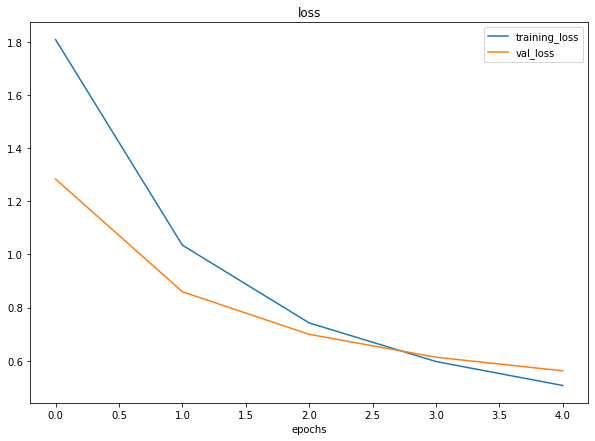

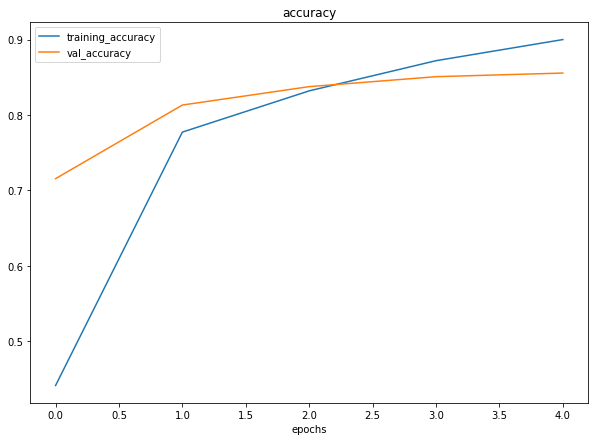

In [23]:
plot_loss_curves(efficientnet_history)

In [26]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [25]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

- **"As is" transfer learning**: pake model yang udah ada tanpa ada perubahan
- **"Feature extraction" transfer learning**: pake model yang udah ada + ngerubah output layer sesuai kebutuhan kita
- **"Fine-tuning" transfer learning**: pake model yang udah ada + "fine-tune" hyperparameternya? (termasuk mengubah output layernya)

In [29]:
len(efficientnet_model.layers[0].weights)

309

## Comparing our models results using TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs. ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
    --one_shot 

2023-01-25 06:27:21.022401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 06:27:21.022998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 06:27:21.032623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 06:27:21.033141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 06:27:21.033955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S